# Predicting Star Ratings Based on Amazon Review Comments of Digital Music Albums

For this project, I will be analyzing Amazon user reviews of digital music. My goal is to predict the star-rating a user will give a product based on the review comment they give. Since the star rating prediction is only based on a text review, it serves as a proxy for building a sentiment classifier – assuming that star rating is truly representative of a review’s sentiment.

## Data Loading and Preliminary Exploration

Import libraries for data processing

In [1]:
import os #used to manage directories
import json #for reading JSON file
import pandas as pd # for data cleaning
import nltk #used for text preprocessing
import numpy as np #for data scrubbing


Set my folder directory path.

In [2]:
# source data from http://jmcauley.ucsd.edu/data/amazon/
os.chdir('C:\My_Files\Analytics\Amazon_reviews\Digital_Music.json')
os.getcwd()

'C:\\My_Files\\Analytics\\Amazon_reviews\\Digital_Music.json'

Load in the JSON file, and print a few sample rows.

In [3]:
data = [json.loads(f) for f in open("Digital_Music.json", 'r')]
type(data) #view data type
data[1:3] #view sample of data

[{'overall': 5.0,
  'verified': True,
  'reviewTime': '09 11, 2013',
  'reviewerID': 'AC2PL52NKPL29',
  'asin': '0001388703',
  'style': {'Format:': ' Audio CD'},
  'reviewerName': 'Norma Mushen',
  'reviewText': 'So creative!  Love his music - the words, the message! Some of my favorite songs on this CD. I should have bought it years ago!',
  'summary': 'Gotta listen to this!',
  'unixReviewTime': 1378857600},
 {'overall': 5.0,
  'verified': True,
  'reviewTime': '03 2, 2013',
  'reviewerID': 'A1SUZXBDZSDQ3A',
  'asin': '0001388703',
  'style': {'Format:': ' Audio CD'},
  'reviewerName': 'Herbert W. Shurley',
  'reviewText': 'Keith Green, gone far to early in his carreer, left us with these few golden alblums to bless us and let us see from a more in sync world veiw or I should say "the language of the modern world\'.\n\nHad this on LP all His alblums..look for ammples and then you will wee what I am talking about.\nGod Bless you all',
  'summary': 'Great approach still gets the messa

Next, I converted the data into a dataframe. Then I printed the dimensions of dataframe, and the distribution of star rating proportions. As seen below, there are ~1.6 Million user review records, and ~80% have a 5-star rating

In [4]:
df = pd.DataFrame(data) #convert to dataframe

print(df.shape)
df.overall.value_counts(normalize = True)

(1584082, 12)


5.0    0.808132
4.0    0.113586
3.0    0.036202
1.0    0.027213
2.0    0.014867
Name: overall, dtype: float64

Since such a high proportion of records have a 5-star rating, I was concerned that it would be hard to interpret the true predictive power of the model based on accuracy in prediction. To slightly mitigate this, I resammpled the dataframe so that a higher proportion of records with star-ratings < 5 were sampled.

For sampling, I assigned higher weights to records that had star ratings < 5

In [5]:
df['Weights'] = np.where(df['overall'] < 5, .75, .25)
df['Weights'].unique()



array([0.25, 0.75])

When sampling based on these weights, the distribution of star ratings become more normalized (~60% with a 5-star rating). 
To minimize time spent on training, I only sampled 10,000 rows. I also made sure to drop any records from the Review and Ratings column that had NA values. 

In [6]:
sample = df.sample(n = 10000, random_state = 10, weights = 'Weights') #create dataframe of 10,000 sample records

sample = sample.dropna(how = 'any', subset = ['reviewText', 'overall'])

In [7]:
###check distribution of star ratings in sample
sample.overall.value_counts(normalize = True)

5.0    0.587670
4.0    0.245396
3.0    0.074660
1.0    0.061249
2.0    0.031025
Name: overall, dtype: float64

Below is a snapshot of the top 5 records in the sampled dataframe

In [8]:
sample.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Weights
1211981,4.0,True,"04 1, 2013",A3I4GB927A6JPA,B00BZOG5JU,{'Format:': ' MP3 Music'},Umberto Borgia,Fans of Donaggio's previous De Palma scores wi...,Donaggio in fine form,1364774400,4,NaN,0.75
32461,5.0,False,"12 7, 2012",A1OQ66R7ZI2GEW,B000W1774O,{'Format:': ' MP3 Music'},gailbop,This is a good song. Johnny Cash at his best. ...,Hurt,1354838400,NaN,NaN,0.25
997656,1.0,False,"03 19, 2011",A1M2KVPOO9JCZH,B004B6HKSE,NaN,Bacchus,I bought this CD thinking the musician was the...,"Not the ""Real"" Eric Andersen",1300492800,NaN,NaN,0.75
1176672,5.0,True,"12 29, 2015",A3HU7471MKOCDR,B00AGBBBL0,{'Format:': ' MP3 Music'},nick,Great song many don't know about,Five Stars,1451347200,NaN,NaN,0.25
785697,1.0,True,"12 14, 2015",A12RD6KVJG5ZK1,B00137Y19U,{'Format:': ' MP3 Music'},Muncie_Birder,I could not get more than half way through rea...,... could not get more than half way through r...,1450051200,NaN,NaN,0.75


## Text Preprocessing

First, I wanted to check the datatypes of each variable in my sampled dataframe

In [9]:
sample.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
image              object
Weights           float64
dtype: object

I converted the star rating column from integer to string so that it could properly feed into subsequent modeling

In [10]:
sample['overall'] = sample['overall'].astype(str)

My next step was to tokenize the words in each record's review text

In [11]:
from nltk import word_tokenize

tokens = [word_tokenize(sen) for sen in sample.reviewText]
# sample['raw_tokens'] = tokens

Then I removed all stop words from the tokenized word list, like "this" and "it's"

In [12]:
from nltk.corpus import stopwords

stoplist = stopwords.words('english')

def removeStopWords(tokens):
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in tokens]

sample['raw_tokens'] = filtered_words #join to dataframe

# sample['Text_Final'] = [' '.join(sen) for sen in filtered_words]
# sample['tokens'] = filtered_words

A snapshot of tokens with removed stop words is seen in the raw_tokens column below.

In [13]:
sample.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Weights,raw_tokens
1211981,4.0,True,"04 1, 2013",A3I4GB927A6JPA,B00BZOG5JU,{'Format:': ' MP3 Music'},Umberto Borgia,Fans of Donaggio's previous De Palma scores wi...,Donaggio in fine form,1364774400,4,NaN,0.75,"[Fans, Donaggio, 's, previous, De, Palma, scor..."
32461,5.0,False,"12 7, 2012",A1OQ66R7ZI2GEW,B000W1774O,{'Format:': ' MP3 Music'},gailbop,This is a good song. Johnny Cash at his best. ...,Hurt,1354838400,NaN,NaN,0.25,"[This, good, song, ., Johnny, Cash, best, ., I..."
997656,1.0,False,"03 19, 2011",A1M2KVPOO9JCZH,B004B6HKSE,NaN,Bacchus,I bought this CD thinking the musician was the...,"Not the ""Real"" Eric Andersen",1300492800,NaN,NaN,0.75,"[I, bought, CD, thinking, musician, wonderful,..."
1176672,5.0,True,"12 29, 2015",A3HU7471MKOCDR,B00AGBBBL0,{'Format:': ' MP3 Music'},nick,Great song many don't know about,Five Stars,1451347200,NaN,NaN,0.25,"[Great, song, many, n't, know]"
785697,1.0,True,"12 14, 2015",A12RD6KVJG5ZK1,B00137Y19U,{'Format:': ' MP3 Music'},Muncie_Birder,I could not get more than half way through rea...,... could not get more than half way through r...,1450051200,NaN,NaN,0.75,"[I, could, get, half, way, really, boring, boo..."


Then I further normalized the data by removing non_ascii words, making everything lowercase, removing punctuation marks, and replacing numbers with words. This is accomplished by the series of functions below.

In [14]:

import re, string, unicodedata
# import contractions
import inflect
from nltk.corpus import stopwords

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
    

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

#remove all punctuation
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words


def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words


The functions were applied to each record in the sampled dataframe. The updated normalized tokens are seen in the tokens column below.

In [15]:
sample['tokens'] = sample['raw_tokens'].apply(lambda x: normalize(x))
sample.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Weights,raw_tokens,tokens
1211981,4.0,True,"04 1, 2013",A3I4GB927A6JPA,B00BZOG5JU,{'Format:': ' MP3 Music'},Umberto Borgia,Fans of Donaggio's previous De Palma scores wi...,Donaggio in fine form,1364774400,4,NaN,0.75,"[Fans, Donaggio, 's, previous, De, Palma, scor...","[fans, donaggio, s, previous, de, palma, score..."
32461,5.0,False,"12 7, 2012",A1OQ66R7ZI2GEW,B000W1774O,{'Format:': ' MP3 Music'},gailbop,This is a good song. Johnny Cash at his best. ...,Hurt,1354838400,NaN,NaN,0.25,"[This, good, song, ., Johnny, Cash, best, ., I...","[this, good, song, johnny, cash, best, it, plu..."
997656,1.0,False,"03 19, 2011",A1M2KVPOO9JCZH,B004B6HKSE,NaN,Bacchus,I bought this CD thinking the musician was the...,"Not the ""Real"" Eric Andersen",1300492800,NaN,NaN,0.75,"[I, bought, CD, thinking, musician, wonderful,...","[i, bought, cd, thinking, musician, wonderful,..."
1176672,5.0,True,"12 29, 2015",A3HU7471MKOCDR,B00AGBBBL0,{'Format:': ' MP3 Music'},nick,Great song many don't know about,Five Stars,1451347200,NaN,NaN,0.25,"[Great, song, many, n't, know]","[great, song, many, nt, know]"
785697,1.0,True,"12 14, 2015",A12RD6KVJG5ZK1,B00137Y19U,{'Format:': ' MP3 Music'},Muncie_Birder,I could not get more than half way through rea...,... could not get more than half way through r...,1450051200,NaN,NaN,0.75,"[I, could, get, half, way, really, boring, boo...","[i, could, get, half, way, really, boring, boo..."


Lastly, I performed stemming on each of the token words. I chose to use Lemmatization, which is a type of stemming technique. These were applied to the same tokens column above.

In [16]:
from nltk.stem import LancasterStemmer, WordNetLemmatizer

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [17]:
sample['tokens'] = sample['tokens'].apply(lambda x: lemmatize_verbs(x))

The next few cells below show the progession of the tokenization and preprocessing for a sample review.

The raw text is shown below.

In [18]:
sample['reviewText'][1506350]

"I can't say I hate this song but it is a little evil and goes against decency.  I wouldn't recommend this for anyone who doesn't practice witch craft."

The tokenized version with removed stopwords is below.

In [19]:
sample['raw_tokens'][1506350]

['I',
 'ca',
 "n't",
 'say',
 'I',
 'hate',
 'song',
 'little',
 'evil',
 'goes',
 'decency',
 '.',
 'I',
 'would',
 "n't",
 'recommend',
 'anyone',
 "n't",
 'practice',
 'witch',
 'craft',
 '.']

And the tokens with complete normalization is shown below.

In [20]:
sample['tokens'][1506350]

['i',
 'ca',
 'nt',
 'say',
 'i',
 'hate',
 'song',
 'little',
 'evil',
 'go',
 'decency',
 'i',
 'would',
 'nt',
 'recommend',
 'anyone',
 'nt',
 'practice',
 'witch',
 'craft']

In [21]:
freq_words = sample.tokens.str.split(expand = True).stack().value_counts()
freq_words

Series([], dtype: int64)

### Word Clouds for Distribution of Words

I was curious how the distribution of words varied for reviews with different star ratings. As a way to visualize this, I created word clouds of the reviews for each star rating 1-5. To supplement this, I also calcuated the top 10 most frequent words and counts for each star rating.

The function below filters the sampled dataframe on a designated star-rating (e.g. '1.0'). Then, a list is created that joins all normalized tokens across all records into a list.

In [22]:
def text_per_rating(rating):
    sample_rating = sample[sample['overall'] == rating]
    text_list = sample_rating['tokens'].tolist() #convert review text to list of tokens
    text_list = list([a for b in text_list for a in b]) #merge across records into a single list
    # text_list[0:50]
    text_list = ' '.join(map(str, text_list)) #remove commas and create list of all words in dataset separated by space
    # concat_text = text_list.str.cat(sep =', ')
    # text_list[0:100]
    return text_list

From this list, the function below counts the frequency of the top 10 words per designated star rating.

In [23]:
from collections import Counter

def freq(rating):
    str_list = text_per_rating(rating)
    str_list = str_list.split()
#     unique_words = set(str_list)
    counts = Counter(str_list)
    counts = counts.most_common(10)
    return counts

A word cloud is also created for each star rating. In the word cloud, I had the option to ignore a custom list of words. I chose exclude words like "album" and "song" from the word cloud because I expected they would be very frequent, but not provide much insight into the sentiment of the reviews per star rating.

In [24]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

def plot_word_clouds(rating):
    text_list = text_per_rating(rating)
    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["album", "song", "cd", "music", "songs"])

    # text_cloud = sample.reviewText
    text_cloud = str(text_list)
    wordcloud = WordCloud(stopwords = stopwords, background_color = "white").generate(text_cloud)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title('Word cloud for {} star rating'.format(rating))
    plt.axis("off")
    plt.show()

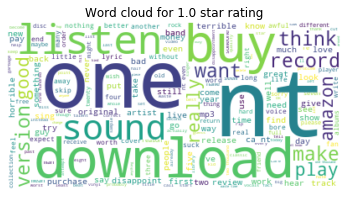

In [25]:
plot_word_clouds('1.0')

In [26]:
freq('1.0')

[('i', 815),
 ('nt', 247),
 ('song', 234),
 ('s', 214),
 ('this', 143),
 ('one', 142),
 ('like', 136),
 ('cd', 132),
 ('the', 132),
 ('it', 130)]

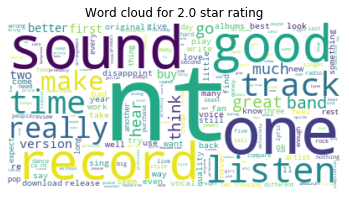

In [27]:
plot_word_clouds('2.0')

In [28]:
freq('2.0')

[('i', 527),
 ('s', 196),
 ('nt', 164),
 ('album', 149),
 ('the', 146),
 ('like', 130),
 ('song', 113),
 ('one', 113),
 ('sound', 112),
 ('songs', 101)]

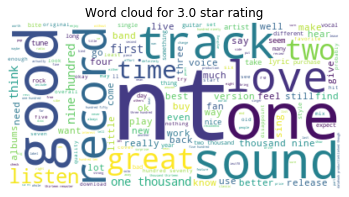

In [29]:
plot_word_clouds('3.0')

In [30]:
freq('3.0')

[('i', 1209),
 ('s', 585),
 ('one', 373),
 ('the', 365),
 ('nt', 348),
 ('and', 330),
 ('song', 323),
 ('album', 305),
 ('like', 293),
 ('hundred', 249)]

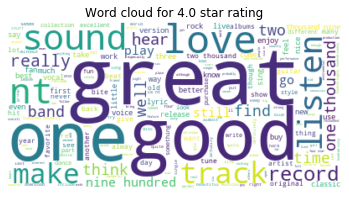

In [31]:
plot_word_clouds('4.0')

In [32]:
freq('4.0')

[('i', 2947),
 ('s', 1567),
 ('song', 1246),
 ('the', 1201),
 ('one', 1019),
 ('album', 955),
 ('like', 884),
 ('good', 820),
 ('great', 755),
 ('music', 752)]

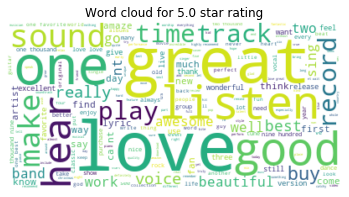

In [33]:
plot_word_clouds('5.0')

In [34]:
freq('5.0')

[('i', 5347),
 ('song', 2641),
 ('love', 2191),
 ('s', 1920),
 ('great', 1736),
 ('music', 1497),
 ('one', 1420),
 ('album', 1387),
 ('the', 1341),
 ('this', 1220)]

As seen from the word clouds and frequencies above, there is a very similar distribution of common words across all star ratings. Even among 1 star ratings, words like "good", "great", and "love" were still very common. However, it's possible these sentiments were negated with preceeding words like 'not good'.

## Predictive Models for Star Rating

### Bag of Words Method

In the BOW model, you can represent a whole sequence of words as a single feature vector.

### Testing on SVM Model

Split training and test data

In [35]:
sample['tokens'][1506350]

['i',
 'ca',
 'nt',
 'say',
 'i',
 'hate',
 'song',
 'little',
 'evil',
 'go',
 'decency',
 'i',
 'would',
 'nt',
 'recommend',
 'anyone',
 'nt',
 'practice',
 'witch',
 'craft']

In [36]:
from sklearn.model_selection import train_test_split

# sentences = sample['tokens'].values
sentences = sample['tokens'].str.join(' ') ## join values into string
y = sample['overall'].values
# y = dummy_y

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

In [37]:
sentences_train[1506350]

'i ca nt say i hate song little evil go decency i would nt recommend anyone nt practice witch craft'

Vectorize the training and test data

In [38]:


from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train



<7494x17376 sparse matrix of type '<class 'numpy.int64'>'
	with 155535 stored elements in Compressed Sparse Row format>

#### SVC Classifier already trained

In [39]:
from sklearn.svm import SVC

from datetime import datetime
start_time = datetime.now()

classifier_svc = SVC()
classifier_svc.fit(X_train, y_train)
score = classifier_svc.score(X_test, y_test)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train

Duration: 0:00:11.733662


In [40]:
print("Accuracy:", score) #print accuracy of SVM model

from sklearn.externals import joblib
import pickle

os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')


joblib.dump(classifier_svc, "classifier_svc.pkl")

Accuracy: 0.6176941553242594


C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['classifier_svc.pkl']

In [41]:
from sklearn.externals import joblib
import pickle

os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')
classifier_svc = joblib.load("classifier_svc.pkl")

score = classifier_svc.score(X_test, y_test)
print("Accuracy:", score) #print accuracy of SVM model

Accuracy: 0.6176941553242594


In [42]:
# classifier_svc.predict(X_test)

In [43]:
from sklearn.metrics import confusion_matrix


predictions = classifier_svc.predict(X_test)

matrix = confusion_matrix(y_test, predictions)
matrix

array([[  14,    0,    1,    0,  117],
       [   2,    0,    3,    3,   62],
       [   0,    0,   14,   10,  150],
       [   0,    0,    0,   36,  593],
       [   0,    0,    6,    8, 1479]], dtype=int64)

In [44]:
# from sklearn.metrics import plot_confusion_matrix
# import matplotlib.pyplot as plt


# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# titles_options = [("Confusion matrix, without normalization", None),
#                   ("Normalized confusion matrix", 'true')]
# for title, normalize in titles_options:
#     disp = plot_confusion_matrix(classifier_svc, X_test, y_test,
#                                  display_labels=['1', '2', '3', '4', '5'],
#                                  cmap=plt.cm.Blues,
#                                  normalize=normalize)
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

# plt.show()

In [45]:
# from sklearn.metrics import confusion_matrix

# predictions = model.predict(X_test)
# # y_pred = (predictions > 0.5)

# # confusion_matrix(y_test, y_pred)

# matrix = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1))
# matrix

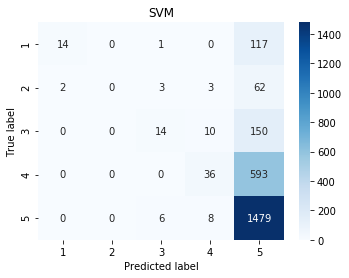

Accuracy: 0.6176941553242594


In [46]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test, predictions) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("SVM")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

# loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))
score = classifier_svc.score(X_test, y_test)
print("Accuracy:", score) #print accuracy of SVM model

In [47]:
from keras import backend as K

def recall_m(y_test, predictions):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predictions, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, predictions):
    precision = precision_m(y_test, predictions)
    recall = recall_m(y_test, predictions)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [48]:
from sklearn.metrics import classification_report

# y_test_norm = y_test.argmax(axis = 1)
# y_test_norm

# predictions = model.predict(X_test, batch_size = 64, verbose = 1)
# y_pred = np.argmax(predictions, axis = 1)
# y_pred

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.88      0.11      0.19       132
         2.0       0.00      0.00      0.00        70
         3.0       0.58      0.08      0.14       174
         4.0       0.63      0.06      0.10       629
         5.0       0.62      0.99      0.76      1493

    accuracy                           0.62      2498
   macro avg       0.54      0.25      0.24      2498
weighted avg       0.61      0.62      0.50      2498



C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Testing on Neural Net

For labeled data, encode the possible start values 1-5 into columns

In [49]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

Y = sample['overall'].values
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoded_Y)
dummy_y

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [50]:
from sklearn.model_selection import train_test_split

# sentences = sample['Text_Final'].values
sentences = sample['tokens'].str.join(' ') ## join values into string
#y = sample['overall'].values
y = dummy_y # use encoded labels for y

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<7494x17376 sparse matrix of type '<class 'numpy.int64'>'
	with 155535 stored elements in Compressed Sparse Row format>

First, I built a sequential model

In [52]:
from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
from keras import layers


input_dim = X_train.shape[1]  # Number of features


model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                173770    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 173,825
Trainable params: 173,825
Non-trainable params: 0
_________________________________________________________________


Train Model

In [53]:
start_time = datetime.now()

nn_bow = model.fit(X_train, y_train,
epochs=20,
verbose=False,
validation_data=(X_test, y_test),
batch_size = 10)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train

Duration: 0:00:47.864183


Save as pickle

In [54]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')


joblib.dump(nn_bow, "nn_bow.pkl")

['nn_bow.pkl']

Load pickle

In [55]:
# os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')
# nn_bow = joblib.load("nn_bow.pkl")

In [56]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9213
Testing Accuracy:  0.6245


In [57]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(nn_bow):
    acc = nn_bow.history['accuracy']
    val_acc = nn_bow.history['val_accuracy']
    loss = nn_bow.history['loss']
    val_loss = nn_bow.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


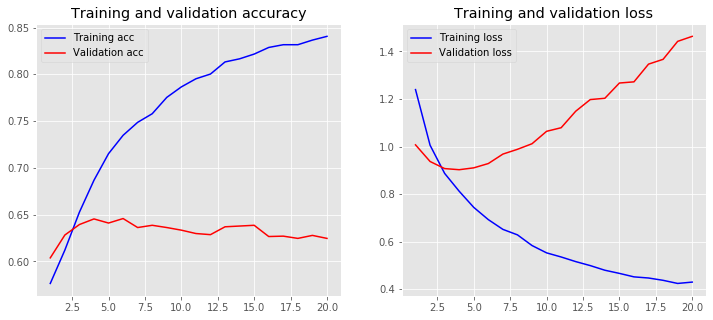

In [58]:
plot_history(nn_bow)

Alternative baseline model:https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [59]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
# y_pred = (predictions > 0.5)

# confusion_matrix(y_test, y_pred)

matrix = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1))
matrix

array([[  64,    1,   16,   18,   33],
       [  16,    3,   15,   14,   22],
       [   7,    3,   45,   58,   61],
       [   7,    0,   28,  239,  355],
       [  22,    4,   24,  234, 1209]], dtype=int64)

In [60]:
loss_trn, accuracy_trn = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_trn))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

Training Accuracy: 0.9213
Testing Accuracy:  0.6245


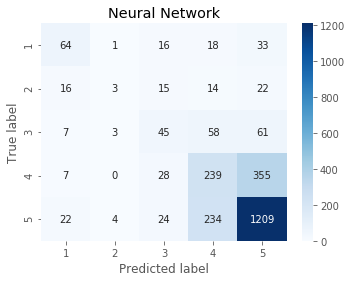

Training Accuracy: 0.9213
Testing Accuracy:  0.6245


In [61]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("Neural Network")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

loss_trn, accuracy_trn = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_trn))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [62]:
from keras import backend as K

def recall_m(y_test, predictions):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predictions, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, predictions):
    precision = precision_m(y_test, predictions)
    recall = recall_m(y_test, predictions)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [63]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

2498/2498 [==============================] - 0s 119us/step
              precision    recall  f1-score   support

           0       0.55      0.48      0.52       132
           1       0.27      0.04      0.07        70
           2       0.35      0.26      0.30       174
           3       0.42      0.38      0.40       629
           4       0.72      0.81      0.76      1493

    accuracy                           0.62      2498
   macro avg       0.46      0.40      0.41      2498
weighted avg       0.60      0.62      0.61      2498



In [64]:
y_test.argmax(axis = 1)

array([4, 4, 3, ..., 4, 4, 4], dtype=int64)

In [65]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

[5, 4, 5, 4]

In [66]:
test_indexes = sentences_test.index
# sample.iloc[test_indexes]
# sample.iloc[[5441],:]

In [67]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
601845,5.0,These were the first two releases from Pallas to feature frontman Alan Reed who replaced Euan Lo...,"[these, first, two, release, pallas, feature, frontman, alan, reed, replace, euan, lowson, mid80...",1,4.0
256188,1.0,I may not be the target audience of Florida but he relies to heavily on auto-tune and spoken wor...,"[i, may, target, audience, florida, rely, heavily, autotune, speak, word, i, nt, recommend]",5,4.0
1252766,1.0,Didn't really work.,"[do, nt, really, work]",5,4.0
1242320,5.0,"sad song. hauntingly lovely. Bc when you think about whatever it is that makes you happy, sad,...","[sad, song, hauntingly, lovely, bc, think, whatever, make, happy, sad, blue, depress, etc, a, li...",1,4.0
966631,1.0,this song doesnt sound like the one on the radio,"[song, doesnt, sound, like, one, radio]",5,4.0
920364,1.0,"Distortion/clipping in the vocals. It's a great song, but this particular MP3 file is not great.","[distortionclipping, vocals, it, s, great, song, particular, mp3, file, great]",5,4.0
653435,1.0,The music is great BUT the sound quality is horrible!! I HIGHLY suggest your buying the 2015 Ja...,"[the, music, great, but, sound, quality, horrible, i, highly, suggest, buy, two thousand and fif...",5,4.0
247608,1.0,"you have to buy this 2 cd set,\nthere is only 1 other song on this 2 cd set that is good, but it...","[buy, two, cd, set, one, song, two, cd, set, good, old, song, another, releaselooks, like, hear,...",5,4.0
800466,1.0,Can download song,"[can, download, song]",5,4.0
101960,1.0,"The 5star reviews of her notwithstanding,I don't believe the voice on this cd is that of Patsy c...","[the, 5star, review, notwithstanding, i, nt, believe, voice, cd, patsy, cline, it, s, close, num...",5,4.0


In [68]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1560
1.0     710
2.0     122
3.0      51
4.0      55
dtype: int64

## Word Embedding

There are 3 main ways to embed: 
1. Words represented by each word as a vector
2. Characters represented by each character as a vector
3. N-grams of words/characters represented as a vector (N-grams are overlapping groups of multiple succeeding words/characters in the text)

I will use method #1. Two ways to do this is via one-hot encoding and word embeddings.

### One-hot encoding

In [69]:
Y = sample['overall'].values
encoder = LabelEncoder()
encoder.fit(Y)
star_labels = encoder.fit_transform(Y)
star_labels

array([3, 4, 0, ..., 4, 4, 4])

In [70]:
from sklearn.preprocessing import OneHotEncoder

len_star = len(star_labels)

encoder = OneHotEncoder(sparse=False)
star_labels = star_labels.reshape((len_star, 1))
encoder.fit_transform(star_labels)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

### Using Word Embeddings

Use Keras' tokenizer to tokenize all words as numeric values. Using the num_words parameter does not have 

In [71]:
sentences_train.iloc[2]

'definitely upbeat inspirational song song encouragement rejoice always ways i highly recommend cd'

In [72]:
from keras.preprocessing.text import Tokenizer

# tokenizer = Tokenizer(num_words = None) #don't filter on top N most common words
tokenizer = Tokenizer(num_words = 5000) # filter on top 5000 most common words
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index)+1  #adding 1 because of reserved 0 index


print(sentences_train[776251]) #print sample review
print(X_train[2]) #print word indexing of sample reiew
len(X_train[2]) #count number of words in sample review

definitely upbeat inspirational song song encouragement rejoice always ways i highly recommend cd
[164, 337, 1863, 3, 3, 2697, 3369, 89, 933, 1, 259, 88, 17]


13

Find index of sample words

In [73]:
for word in ['good', 'bad', 'terrible']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

good: 13
bad: 142
terrible: 698


Find top 10 most frequent words

In [74]:
tokens_list = list(tokenizer.word_index)
tokens_list[0:10]

['i', 's', 'song', 'one', 'the', 'album', 'love', 'great', 'music', 'nt']

### Padding

In [75]:
maxlen = max([len(listElem.split()) for listElem in sentences]) ##find length of review with max number of words

In [76]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0:5, :])

[[ 134   13 1008 ...    0    0    0]
 [   1    7    9 ...    0    0    0]
 [ 164  337 1863 ...    0    0    0]
 [  14   89 1459 ...    0    0    0]
 [  12   62   21 ...    0    0    0]]


In [77]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3417, 50)          869950    
_________________________________________________________________
flatten_1 (Flatten)          (None, 170850)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1708510   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
Total params: 2,578,515
Trainable params: 2,578,515
Non-trainable params: 0
_________________________________________________________________


Check: https://github.com/tflearn/tflearn/issues/260

In [78]:
start_time = datetime.now()

nn_embed = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train



C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Duration: 0:07:10.892900


In [79]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')

joblib.dump(nn_embed, "nn_embed.pkl")

['nn_embed.pkl']

In [80]:
# os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')
# nn_embed = joblib.load("nn_embed.pkl")

In [81]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9608
Testing Accuracy:  0.5857


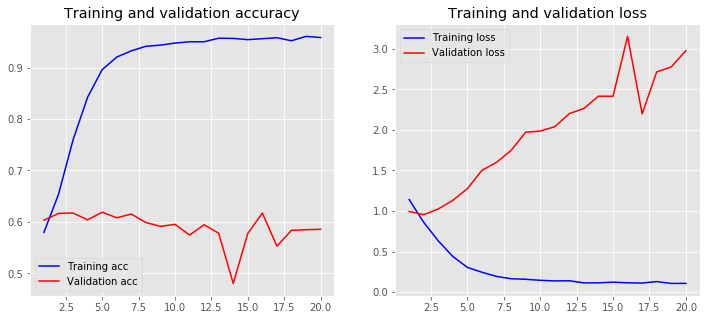

In [82]:
plot_history(nn_embed)

In [83]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
# y_pred = (predictions > 0.5)

# confusion_matrix(y_test, y_pred)

matrix = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1))
matrix

array([[  34,    3,   14,   14,   67],
       [  10,    2,    8,   12,   38],
       [   4,    2,   21,   56,   91],
       [   8,    2,   22,  180,  417],
       [   7,    2,   25,  233, 1226]], dtype=int64)

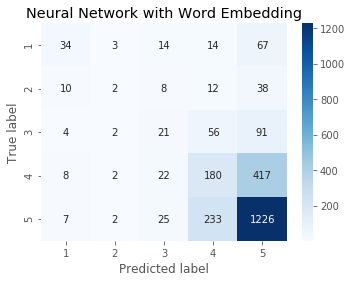

Training Accuracy: 0.9608
Testing Accuracy:  0.5857


In [84]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("Neural Network with Word Embedding")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


In [85]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

2498/2498 [==============================] - 1s 230us/step
              precision    recall  f1-score   support

           0       0.54      0.26      0.35       132
           1       0.18      0.03      0.05        70
           2       0.23      0.12      0.16       174
           3       0.36      0.29      0.32       629
           4       0.67      0.82      0.74      1493

    accuracy                           0.59      2498
   macro avg       0.40      0.30      0.32      2498
weighted avg       0.54      0.59      0.55      2498



## CNN

In [86]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3417, 100)         1739900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3413, 128)         64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 55        
Total params: 1,805,373
Trainable params: 1,805,373
Non-trainable params: 0
_________________________________________________________________


In [87]:
start_time = datetime.now()

cnn_model = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train


C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Duration: 0:28:55.655138


In [88]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')

joblib.dump(cnn_model, "cnn_model.pkl")

['cnn_model.pkl']

In [89]:
# os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')

# cnn_model = joblib.load("cnn_model.pkl")

In [90]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9677
Testing Accuracy:  0.5649


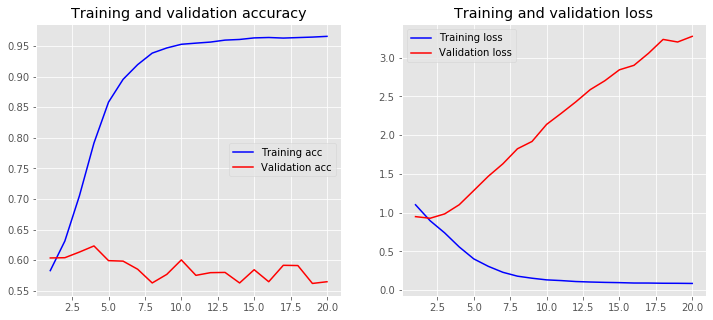

In [91]:
plot_history(cnn_model)

In [92]:
y_test[1]

array([0., 0., 0., 0., 1.], dtype=float32)

https://stackoverflow.com/questions/50920908/get-confusion-matrix-from-a-keras-multiclass-model

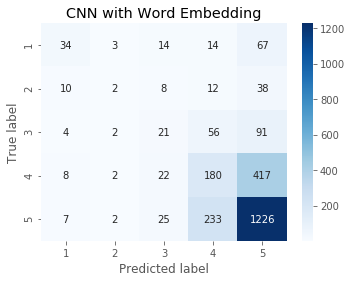

Training Accuracy: 0.9677
Testing Accuracy:  0.5649


In [93]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("CNN with Word Embedding")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [94]:
from keras import backend as K

def recall_m(y_test, predictions):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predictions, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, predictions):
    precision = precision_m(y_test, predictions)
    recall = recall_m(y_test, predictions)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [95]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

2498/2498 [==============================] - 6s 2ms/step
              precision    recall  f1-score   support

           0       0.55      0.33      0.41       132
           1       0.14      0.20      0.17        70
           2       0.23      0.32      0.27       174
           3       0.38      0.36      0.37       629
           4       0.73      0.72      0.72      1493

    accuracy                           0.56      2498
   macro avg       0.41      0.39      0.39      2498
weighted avg       0.58      0.56      0.57      2498



## Pretrained gLOVE model Method 1

In [96]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding = "utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [97]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\glove_6B')


embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)


In [98]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8265417552732915

In [99]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 3417, 50)          869950    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
Total params: 870,515
Trainable params: 870,515
Non-trainable params: 0
_________________________________________________________________


In [100]:
start_time = datetime.now()

nn_glove = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train


C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Duration: 0:04:37.699281


In [101]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')

joblib.dump(nn_glove, "nn_glove.pkl")

['nn_glove.pkl']

In [102]:
# os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')
# nn_glove = joblib.load("nn_glove.pkl")

In [103]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9254
Testing Accuracy:  0.5733


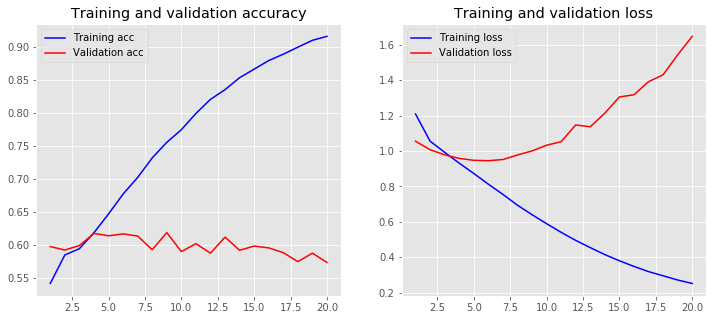

In [104]:
plot_history(nn_glove)

In [105]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
# y_pred = (predictions > 0.5)

# confusion_matrix(y_test, y_pred)

matrix = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1))
matrix

array([[  53,    1,   21,   22,   35],
       [  15,    2,   13,   13,   27],
       [  13,    3,   38,   52,   68],
       [   7,    2,   25,  239,  356],
       [  25,    0,   39,  329, 1100]], dtype=int64)

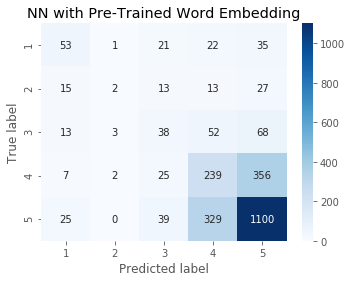

Training Accuracy: 0.9254
Testing Accuracy:  0.5733


In [106]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("NN with Pre-Trained Word Embedding")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [107]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

2498/2498 [==============================] - 1s 250us/step
              precision    recall  f1-score   support

           0       0.47      0.40      0.43       132
           1       0.25      0.03      0.05        70
           2       0.28      0.22      0.25       174
           3       0.36      0.38      0.37       629
           4       0.69      0.74      0.71      1493

    accuracy                           0.57      2498
   macro avg       0.41      0.35      0.36      2498
weighted avg       0.56      0.57      0.56      2498



### CNN with Pre-trained Embeddings

In [108]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen,
                          weights = [embedding_matrix],
                          trainable = True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 3417, 50)          869950    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3413, 128)         32128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
Total params: 903,423
Trainable params: 903,423
Non-trainable params: 0
_________________________________________________________________


In [109]:
start_time = datetime.now()

cnn_glove = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train


C:\Users\oshap\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Duration: 0:18:31.120278


In [110]:
os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')

joblib.dump(cnn_glove, "cnn_glove.pkl")

['cnn_glove.pkl']

In [111]:
# os.chdir('C:\My_Files\Analytics\Amazon_reviews\pickles')
# cnn_glove = joblib.load("cnn_bow.pkl")

In [112]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9638
Testing Accuracy:  0.5697


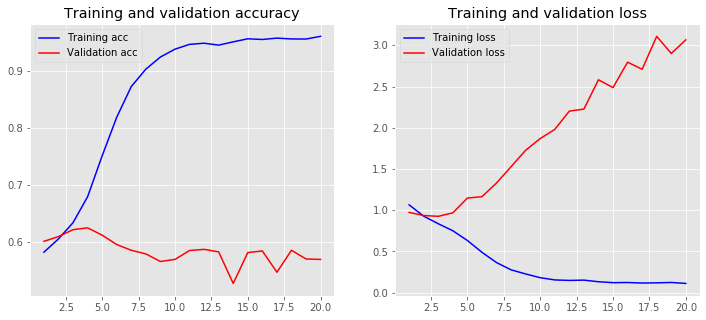

In [113]:
plot_history(cnn_glove)

In [114]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
# y_pred = (predictions > 0.5)

# confusion_matrix(y_test, y_pred)

matrix = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1))
matrix

array([[  49,    5,   41,   22,   15],
       [  13,    5,   21,   14,   17],
       [  11,    4,   48,   64,   47],
       [  10,    6,   72,  216,  325],
       [   8,    6,   89,  285, 1105]], dtype=int64)

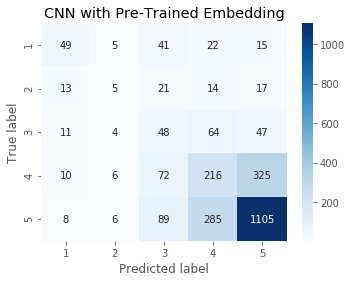

Training Accuracy: 0.9638
Testing Accuracy:  0.5697


In [115]:
import seaborn as sns
# clf = SVC(kernel = 'linear').fit(x_train,y_train)
# clf.predict(x_train)
# y_pred = clf.predict(x_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
# plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(model.evaluate(X_test, y_test, verbose=False)))
# plt.title("Training Accuracy: {:.4f}".format(accuracy_trn) + "\n Testing Accuracy:  {:.4f}".format(accuracy_test))
plt.title("CNN with Pre-Trained Embedding")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [116]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

2498/2498 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       0.54      0.37      0.44       132
           1       0.19      0.07      0.10        70
           2       0.18      0.28      0.22       174
           3       0.36      0.34      0.35       629
           4       0.73      0.74      0.74      1493

    accuracy                           0.57      2498
   macro avg       0.40      0.36      0.37      2498
weighted avg       0.57      0.57      0.57      2498



In [117]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

[5, 5, 5, 4]

In [118]:
test_indexes = sentences_test.index
# sample.iloc[test_indexes]
# sample.iloc[[5441],:]

In [119]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
800466,1.0,Can download song,"[can, download, song]",5,4.0
1059294,1.0,This cd never make in cd only vinyl this is not original thanks,"[this, cd, never, make, cd, vinyl, original, thank]",5,4.0
1269703,1.0,there is weird drumming over this. Like some one over dubbed their drumming exercises.,"[weird, drum, like, one, dub, drum, exercise]",5,4.0
1367850,5.0,Luv it!,[luv],1,4.0
1304550,1.0,its not dubstep... just like some liquid sounds and not much of a good beat or melody either.......,"[dubstep, like, liquid, sound, much, good, beat, melody, either, sorry, bro, lol]",5,4.0
920470,1.0,I wanted tool not a quartet,"[i, want, tool, quartet]",5,4.0
76619,5.0,"Found this song, thought it was the real deal but it was a cover. Searched for, and found, the ...","[find, song, think, real, deal, cover, search, find, original, thirty, cents, waste, ninety-nine...",1,4.0
480155,5.0,"So Roger doesn't like Israel fine don't play , but wait Roger doesn't like the US wall and he is...","[so, roger, nt, like, israel, fine, nt, play, wait, roger, nt, like, us, wall, play, every, nook...",1,4.0
751504,5.0,"This CD has the real music of trujillo's era, if you want to listen to real and classic merengue...","[this, cd, real, music, trujillo, s, era, want, listen, real, classic, merengue, music, product,...",1,4.0
848490,1.0,"This not a ""clean"" version. It says ""ass"" in the song. I cannot use this song for an exercise ...","[this, clean, version, it, say, ass, song, i, use, song, exercise, class]",5,4.0


In [120]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1423
1.0     789
2.0     208
3.0      55
4.0      23
dtype: int64

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

## Hyperparamaterization

In [121]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [122]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [123]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 10
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
sentences = df['Final_Text'].values
y = df['overall'].values

# Train-test split
sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000)

# Tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                        epochs=epochs, batch_size=10,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

# Save and evaluate results
prompt = input(f'finished {source}; write to file and proceed? [y/n]')
if prompt.lower() not in {'y', 'true', 'yes'}:
    break
with open(output_file, 'a') as f:
#     s = ('Running {} data set\nBest Accuracy : ' '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
#         grid_result.best_score_,
#         grid_result.best_params_,
#         test_accuracy)
    print(output_string)
    f.write(output_string)

SyntaxError: invalid syntax (<ipython-input-123-2a56c4faae28>, line 58)

In [ ]:
[word for tokens in data_train["tokens"] for word in tokens][2]

In [ ]:
data_train["tokens"]

In [ ]:
##split training and test data
data_train, data_test = train_test_split(sample, 
                                         test_size=0.10, 
                                         random_state=42)

##calculate total number of training words
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
##get lengths of all token strings in training data
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
#sorted list of training vocabulary
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

##repeat process for test data
all_test_words = [word for tokens in data_test['tokens'] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test['tokens']]
TEST_VOCAB = sorted(list(set(all_test_words)))
print('%s words total, with a vocabulary size of %s' % (len(all_test_words), len(TEST_VOCAB)))
print('Max sentence length is %s' % max(test_sentence_lengths))

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer #used to tokenize data
from tensorflow.keras.preprocessing.sequence import pad_sequences #used to pad sequences

MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300

#tokenize and pad sequences
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
# tokenizer.fit_on_texts(data_train['Text_Final'].tolist())
tokenizer.fit_on_texts(data_train['Text_Final'].tolist())
X_train = tokenizer.texts_to_sequences(data_train['Text_Final']


In [ ]:

training_sequences = tokenizer.texts_to_sequences(data_train['Text_Final'].tolist())
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))
train_cnn_data = pad_sequences(training_sequences, 
                               maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
# print(data_train['Text_Final'].tolist()[2])
print(sentences_train[2])
print(training_sequences[2])

In [ ]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
# sentences = sample['Text_Final'].values
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# vectorizer.fit(sentences)

# X_cf = vectorizer.transform(sentences)
# X_cf.shape[1]


# input_dim_cf = X_cf.shape[1]  # Number of features


In [ ]:
# # define baseline model
# def baseline_model():
# # create model
#     model = Sequential()
#     model.add(Dense(8, input_dim=1, activation='relu'))
#     model.add(Dense(5, activation='softmax'))
#     # Compile model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [ ]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from keras.layers import Dense

# estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=False)
# kfold = KFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, sentences, y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# star_1= []
# star_2 = []
# star_3 = []
# star_4 = []
# star_5 = []
# for l in sample.overall:
#     if l == 1.0:
#         star_1.append(1)
#         star_2.append(0)
#         star_3.append(0)
#         star_4.append(0)
#         star_5.append(0)
#     elif l == 2.0:
#         star_1.append(0)
#         star_2.append(1)
#         star_3.append(0)
#         star_4.append(0)
#         star_5.append(0)
#     elif l == 3.0:
#         star_1.append(0)
#         star_2.append(0)
#         star_3.append(1)
#         star_4.append(0)
#         star_5.append(0)
#     elif l == 4.0:
#         star_1.append(0)
#         star_2.append(0)
#         star_3.append(0)
#         star_4.append(1)
#         star_5.append(0)
#     elif l == 5.0:
#         star_1.append(0)
#         star_2.append(0)
#         star_3.append(0)
#         star_4.append(0)
#         star_5.append(1)

# sample['star_1'] = star_1
# sample['star_2'] = star_2
# sample['star_3'] = star_3
# sample['star_4'] = star_4
# sample['star_5'] = star_5

Next, I split the dataframe into training and test data for validation. Then I counted the number of total and unique words (vocabulary size) for both the training and testing datasets.

In [ ]:
from sklearn.model_selection import train_test_split 
##split training and test data
data_train, data_test = train_test_split(sample, 
                                         test_size=0.10, 
                                         random_state=42)

##calculate total number of training words
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
##get lengths of all token strings in training data
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
#sorted list of training vocabulary
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

##repeat process for test data
all_test_words = [word for tokens in data_test['tokens'] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test['tokens']]
TEST_VOCAB = sorted(list(set(all_test_words)))
print('%s words total, with a vocabulary size of %s' % (len(all_test_words), len(TEST_VOCAB)))
print('Max sentence length is %s' % max(test_sentence_lengths))




## Preparing the Embedding Layer

Method 1: Training embeddings
https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn


Method 2: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer #used to tokenize data
from tensorflow.keras.preprocessing.sequence import pad_sequences #used to pad sequences


#tokenize and pad sequences
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train['Text_Final'].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train['Text_Final'].tolist())
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))
train_cnn_data = pad_sequences(training_sequences, 
                               maxlen=MAX_SEQUENCE_LENGTH)